# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL (CS-401). 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### Import libraries

In [1]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from langdetect import detect
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
import time

from textstat import flesch_reading_ease, flesch_kincaid_grade, gunning_fog, smog_index, automated_readability_index, coleman_liau_index, linsear_write_formula, dale_chall_readability_score, text_standard
from utils import *
pd.set_option('display.max_columns', None)

dataset_path = './data/BeerAdvocate/'

## 1. Datasets 📂

### 1.1 Import dataset

In [ ]:
# Firt time imports : 
# Convert txt to csv (function in the utils.py file)

#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

In [2]:
# Files already converted, so we can load them directly

reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### 1.2 Initial datasets analysis 🔎

#### 1.2.1 Beers dataset 🍺

In [3]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
166841,130384,Tennessee Brew Sessions: American Pale Session...,32792,Tennessee Brew Works,American Pale Ale (APA),9,0,3.84,NaN,NaN,NaN,3.836667,NaN,0,NaN
222642,135164,Commodore Perry W/ Mango,73,Great Lakes Brewing Co.,English India Pale Ale (IPA),2,0,3.90,NaN,NaN,6.0,3.900000,NaN,0,NaN
279492,160346,St. Norm Hopped Tripel,21593,Thirsty Monk,Tripel,2,0,3.81,NaN,NaN,8.5,3.810000,NaN,0,NaN


Shape of beers :  (280823, 15)


In [4]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

In [30]:
def show_missing(df):
    """
    This function receives a dataframe and plots the percentage of missing values per column. It also prints for each column with missing values the number of missing values and the percentage of missing values. If there are no missing values, it prints a message saying so.
    """
    # check if there are any missing values
    if df.isna().sum().sum() == 0:
        print('There are no missing values in this dataset.')
        return
    else:
        # show the percentage of missing values per columm
        plt.figure()
        (df.isna().sum() / len(df) * 100).plot(kind='barh', title='Percentage of missing values per column')
        plt.xlabel('Percentage of missing values')
        plt.show()

        missing_values = df.isnull().sum()
        total_values = df.shape[0]
        missing_percentage = missing_values / total_values * 100
        for col in df.columns:
            if missing_values[col] > 0:
                print("{:<25}: {:>5} missing values ({:.2f}%)".format(col, missing_values[col], missing_percentage[col]))


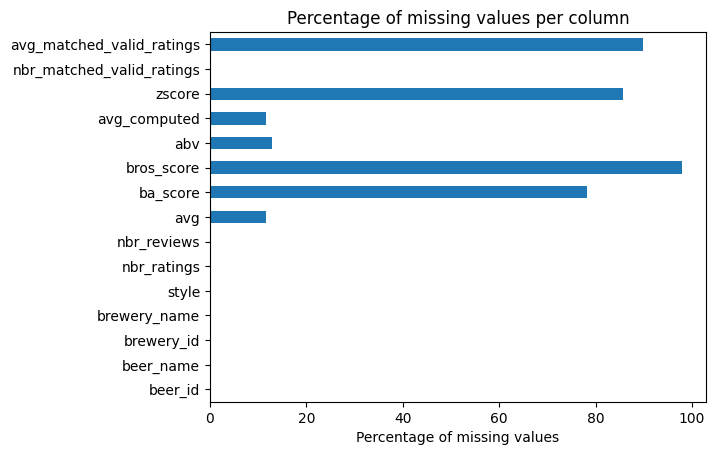

avg                      : 32829 missing values (11.69%)
ba_score                 : 219623 missing values (78.21%)
bros_score               : 275121 missing values (97.97%)
abv                      : 36024 missing values (12.83%)
avg_computed             : 32841 missing values (11.69%)
zscore                   : 240538 missing values (85.65%)
avg_matched_valid_ratings: 252551 missing values (89.93%)


In [31]:
show_missing(beers)

<blockquote>

**More comments about the dataset**

We see that more than 80% of the beers do not have a z-score value. We can drop this column alongside avg_computed and compute them manually later if needed from the reviews dataset. 

80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

The other columns with NaN such as avg_matched_valid_ratings, avg_computed or bros_score are not usefull in our analysis since we only look at the BeerAdvocate reviews.

However, the abv, which represents the alcohol percentage in a beer, is missing for approximately 12%.

</blockquote>

In [21]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [22]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
235727,217,5316,Winter Warmer,867,486,3.82,7.20
12002,54297,10544,American Adjunct Lager,3,2,1.88,5.00
84901,6060,447,American Adjunct Lager,20,11,2.22,4.73


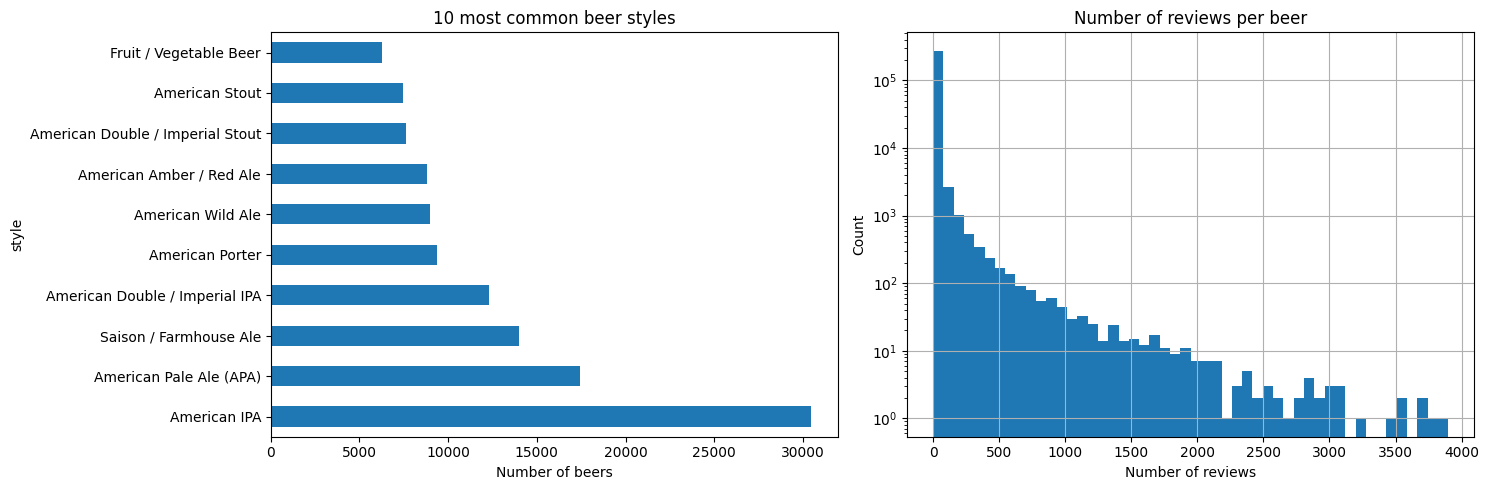

In [23]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

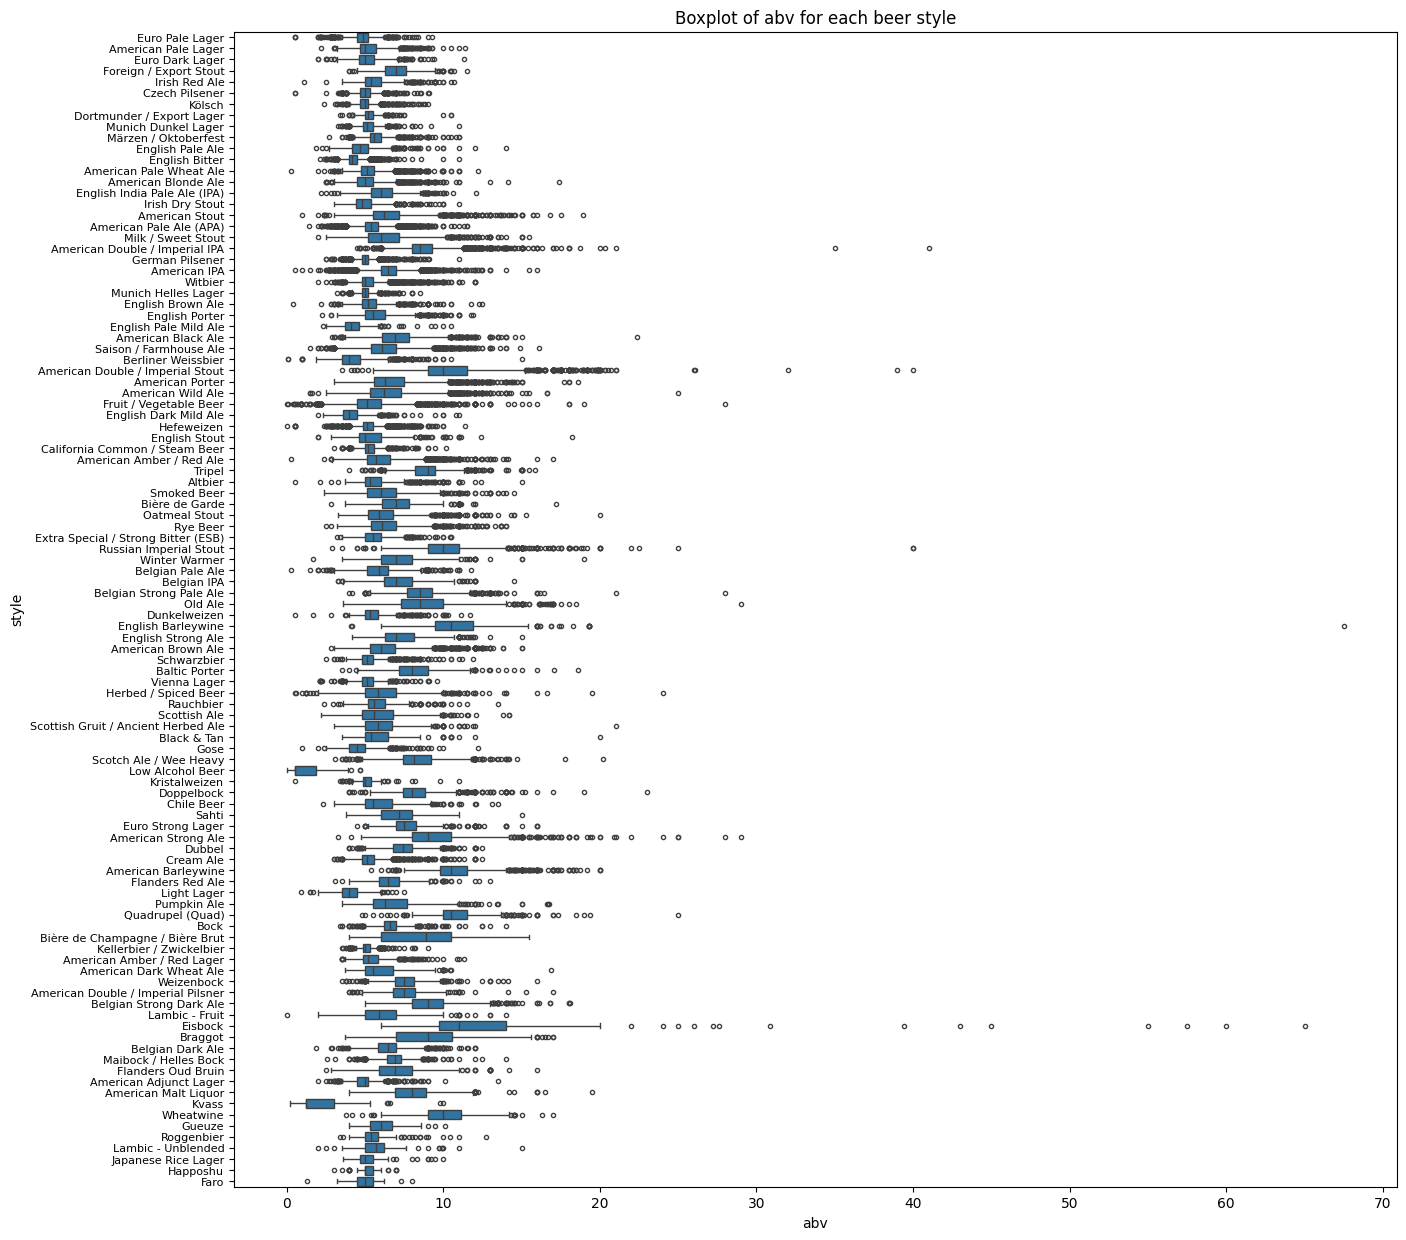

In [24]:
# show boxplot of abv for each beer style
plt.figure(figsize=(15, 15))
sns.boxplot(y='style', x='abv', data=beers_filtered, fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for each beer style')
plt.show()

In [26]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
# display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

In [27]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### 1.2.2 Breweries dataset 🏭

In [28]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
4477,6618,Germany,Eltviller Brauhaus,0
16596,11342,"United States, California",Schooner's Grille & Brewery,18
5706,12534,Australia,Bright Brewery,19


Shape of breweries :  (16758, 4)


In [32]:
# show the missing values
show_missing(breweries)

There are no missing values in this dataset.


<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [33]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [34]:
breweries_filtered.sample(3)

,brewery_id,brewery_location,brewery_nbr_beers
9748,26419,"United States, New York",11
9157,34277,"United States, Washington",15
7007,49213,Netherlands,2


In [35]:
# Some breweries have weird location values, they contain google maps links.
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# should manully add the us state of the 35 breweries because it corresponds to to 15'319 reviews.

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [37]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'
    
# function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [38]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [39]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [40]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [41]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


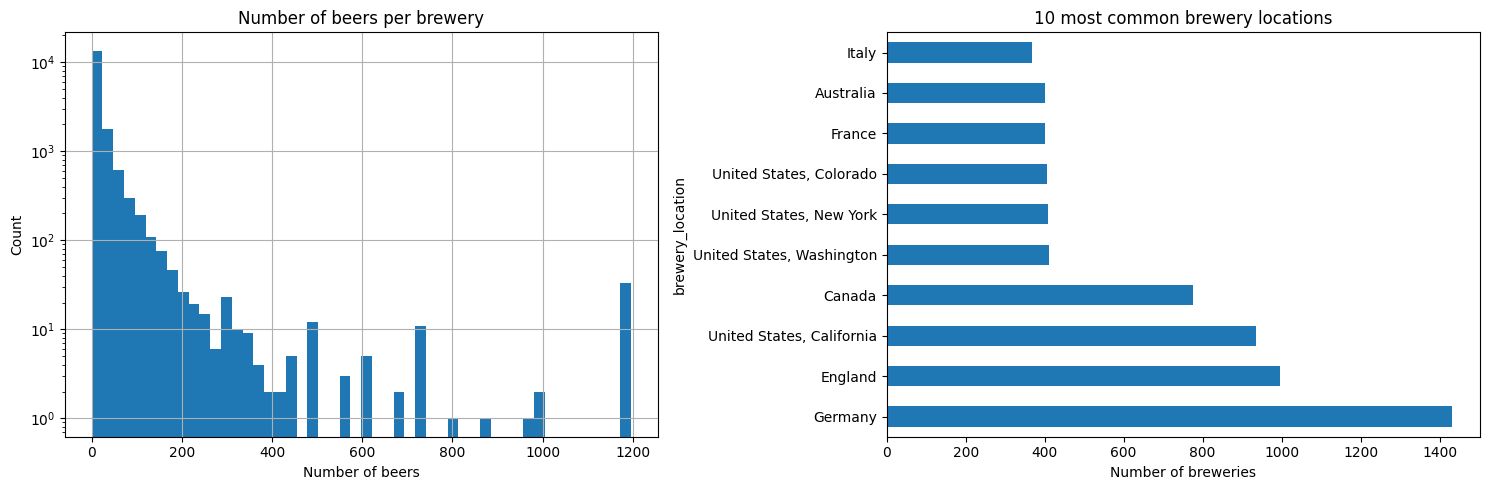

In [42]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### 1.2.3 Users dataset 👤

In [43]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
112657,4,0,beernoob129.906817,beernoob129,1.418296e+09,"United States, Minnesota"
54386,2,0,tsraven456.568008,tsraven456,1.297854e+09,"United States, Pennsylvania"
73397,67,0,bonsbeer.1202446,BonsBeer,1.496743e+09,"United States, California"


Shape of users :  (153704, 6)


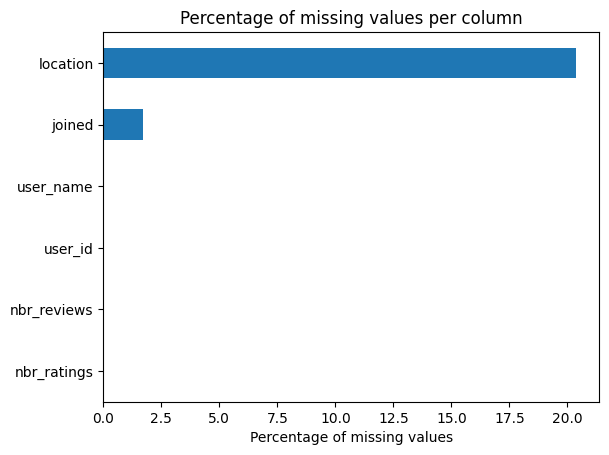

user_name                :     1 missing values (0.00%)
joined                   :  2652 missing values (1.73%)
location                 : 31279 missing values (20.35%)


In [44]:
show_missing(users)

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [45]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

users_filtered.sample(3)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
53319,30,0,indyblue9.839934,1.407233e+09,"United States, Indiana"
83815,2,0,cleaythompson.694589,1.347790e+09,NaN
25406,78,0,ems.848051,1.408356e+09,"United States, New York"


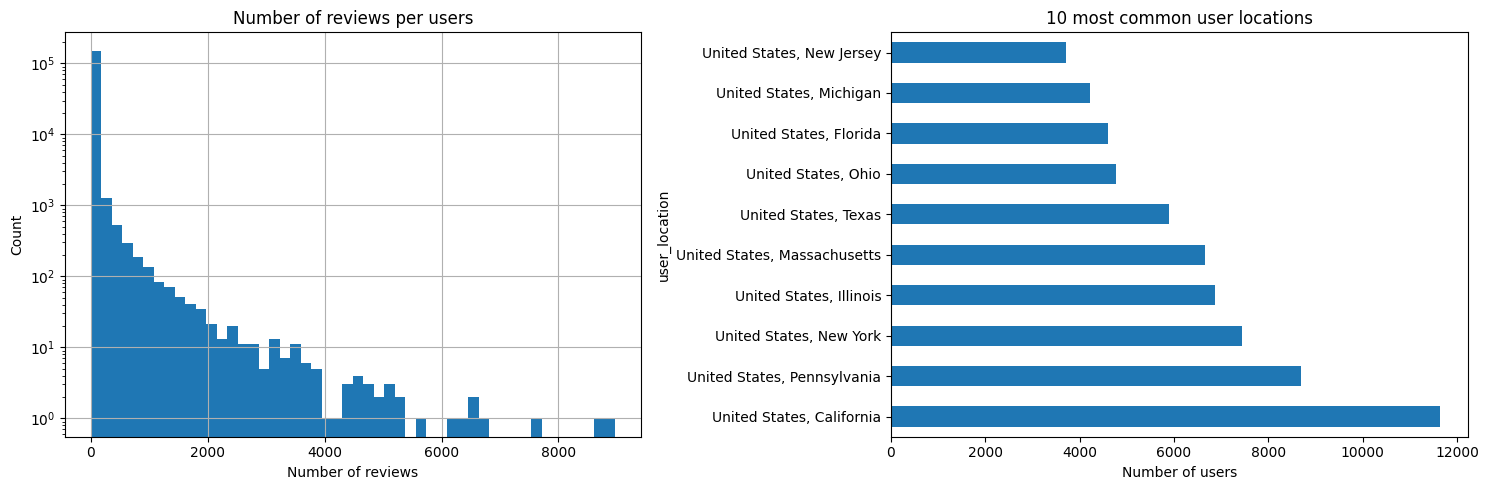

In [46]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### 1.2.4 Reviews dataset 📝

In [47]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
2118247,Dark Horse Perkulator Coffee Dopplebock,39129,Dark Horse Brewing Company,1471,Doppelbock,7.0,1323860400,phlegon,phlegon.506077,4.0,4.5,3.0,2.5,3.0,3.22,I enjoy a good cup of coffee and a good brew s...
2155367,Figgy Pudding,63672,Block 15 Brewery & Restaurant,16846,English Strong Ale,11.0,1326625200,MBrausen,mbrausen.600384,4.0,4.0,3.5,4.0,3.5,3.85,Thanks to Dougofthefuture for holding this tas...
962492,Baggywrinkle Barleywine,2237,Cisco Brewers Inc.,261,English Barleywine,9.0,1290942000,Thorpe429,thorpe429.243272,3.0,3.0,3.0,2.5,3.0,2.80,Thanks to Drew for giving us this bottle. Serv...


Shape of reviews :  (2589586, 16)


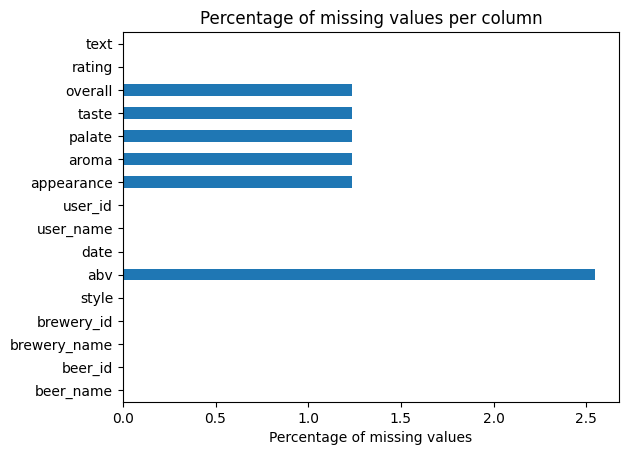

abv                      : 65983 missing values (2.55%)
user_name                :     3 missing values (0.00%)
appearance               : 32009 missing values (1.24%)
aroma                    : 32009 missing values (1.24%)
palate                   : 32009 missing values (1.24%)
taste                    : 32009 missing values (1.24%)
overall                  : 32009 missing values (1.24%)
text                     :     2 missing values (0.00%)


In [48]:
show_missing(reviews)

In [51]:
# making sure that all the missing values of the rating aspects are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
print()
# print the number of rows that contains a NaN value for all the rating aspects
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009

all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [54]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

#remove the two reviews that have no text
reviews_filtered = reviews_filtered[~reviews_filtered['text'].isna()].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
2404720,1703,388,Gueuze,1309687200,barleywinefiend.174542,4.0,4.0,4.5,4.5,4.5,4.35,A: Poured a hazy golden orange color with a ni...
852962,37326,147,Belgian Strong Pale Ale,1247392800,mrmonkey.140353,4.0,4.5,3.5,4.0,3.5,3.97,Reviewed from notes taken a few nights ago.Pou...
745452,55798,5411,English Barleywine,1276509600,ghenna.380478,4.0,3.0,3.5,3.0,4.0,3.31,Picked this up from the Davis foods co-op for ...


Shape of reviews_filtered :  (2557575, 12)


In [55]:
show_missing(reviews_filtered)

There are no missing values in this dataset.


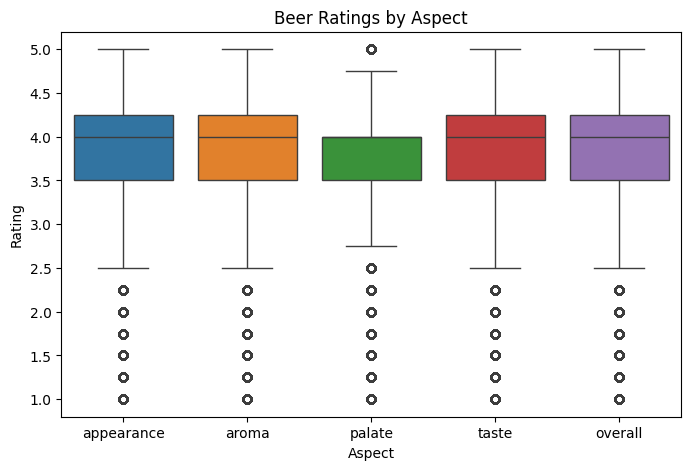

In [56]:
# show boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### 1.3 Merge datasets 🔗

In [57]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
2265143,17141,1146,American Pale Wheat Ale,1364554800,chiefy770.617011,3.25,3.0,3.75,3.75,3.75,3.54,Poured from bottle into a Weizen glass.A: Ligh...,4544,925,3.42,4.2,210,197,1.313834e+09,"United States, Illinois","United States, Illinois",869


Shape of df_merged :  (2557575, 22)


### 1.4 Filter datasets ✂️

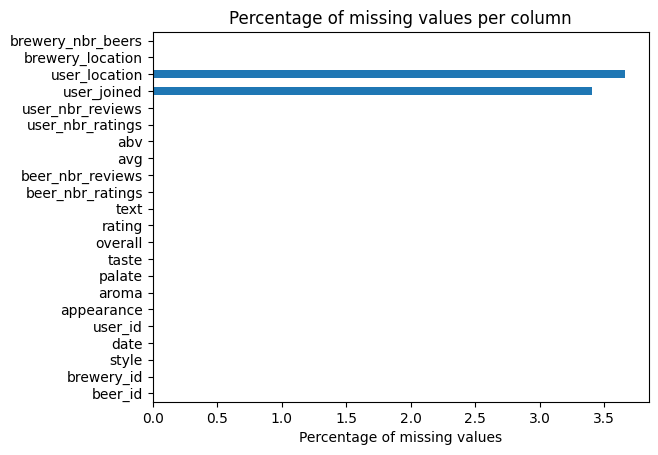

user_joined              : 87150 missing values (3.41%)
user_location            : 93668 missing values (3.66%)


In [58]:
show_missing(df_merged)

In [59]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

> We have a complete dataset. Only information about the location of 3.66% of users is missing.

In [60]:
# Save to csv
df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

## 2. Data enrichment 🍺

In [61]:
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [62]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
483143,9531,1550,American Stout,1050919200,atlagerheads.1671,4.0,3.5,4.0,4.0,4.0,3.88,Another good Cincy RBRB offering. A very dark ...,1,1,3.88,6.2,886,886,1.046689e+09,"United States, Ohio","United States, Colorado",1196
415920,191070,209,English India Pale Ale (IPA),1446894000,tx-badger.680921,2.5,2.5,2.5,2.5,2.5,2.50,Pours a clear golden color with thick creamy w...,772,239,2.99,5.8,2844,1456,1.339668e+09,"United States, Texas",Ireland,53
1387221,16471,898,American Double / Imperial Pilsner,1330254000,teromous.440420,4.5,3.0,3.0,2.5,3.0,2.89,"A: Burnished gold color, thick and fluffy head...",1099,591,3.78,7.0,1020,1019,1.269169e+09,"United States, Virginia","United States, Maryland",131


Shape of df :  (2557575, 22)


### 2.1 Serving style 🍾🥤🚰

#### 2.1.1 naive approach

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served. 
For now, we use a naive approach. We only look at whether a word specific to as service style has been used. 

In [63]:
def serving_type_naive(df):
    # Create 3 different columns according to the text review, "bottle", "can", "draft"
    bottle = {'bottle', 'bottled', 'bottles', 'growler', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask'}
    
    # Create different columns if review text contains the word
    df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
    df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
    df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))
    
    # if there are more than one true or no true, set the value to 'unknown'
    df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'

    # drop the columns bottle, can and draft
    df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)
    return df

#### 2.1.2 Similarity 🍾🥤🚰

> Check list of words and remove every words associated with the glass since most users will drink their beer from a glass regardless of the serving style.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def serving_type_sim(df, word_bottle='data/bottle.txt', word_can='data/can.txt', word_draft='data/draft.txt', threshold=0.5):
    # Read the list of words from the text file
    with open(word_can, 'r') as file:
        word_can = file.read().splitlines()

    with open(word_bottle, 'r') as file:
        word_bottle = file.read().splitlines()

    with open(word_draft, 'r') as file:
        word_draft = file.read().splitlines()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the review and words list using TF-IDF
    tfidf_matrix = vectorizer.fit_transform(df['text'].astype(str))

    can_vector = vectorizer.transform([" ".join(word_can)])
    bottle_vector = vectorizer.transform([" ".join(word_bottle)])
    draft_vector = vectorizer.transform([" ".join(word_draft)])

    # Calculate the cosine similarity
    cosine_sim_can = cosine_similarity(tfidf_matrix, can_vector)
    cosine_sim_bottle = cosine_similarity(tfidf_matrix, bottle_vector)
    cosine_sim_draft = cosine_similarity(tfidf_matrix, draft_vector)

    # Get the maximum similarity score and corresponding serving type
    max_sim = np.maximum.reduce([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft])
    serving_type = np.where(max_sim >= threshold, np.array(['bottle', 'can', 'draft'])[np.argmax([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft], axis=0)], 'unknown')

    # Add the serving_type_sim column to the dataframe
    df['serving_type_sim'] = serving_type

    return df

<blockquote>
It seems to work for most reviews. It might be interesting to save this feature in the reviews df and compare it to the naive method. 

For a few example, two similarity score seems to come close. <br>
<hr>

*poured from a 500 ml bottle into a nonic pint. excellent label of a beer-swilling elephant riding a steam engine. a hilariously sick tribute to local martyr &quot;jumbo&quot;, p.t. barnum's famous elephant, who was crushed to death by a train in st. thomas in the 1880's.deep, clear gold tending toward amber, with a tight creamy head that eventually settles down to a soft, white collar. good lacing.smell is some spicy, piney c-hop; sweet, toffee-like malt; and on the fainter side.taste follows smell. the principal malt character is toffee-like sweetness. intensely sweet upfront, followed by a prickly bitterness that smooths out on the way down and rears its head in the lingering, bittersweet aftertaste. it actually leans toward sweet to the point of underbalance, if only slightly. the faintest hints of staleness/infection (one of the flavors i'm actually quite good at picking out), but nothing serious.mouthfeel is moderate/full, lighter carbonation, refreshing.only okay drinkability. i can't put my finger on it, but with every sip i find myself wanting less. it's definitely leans toward the sticky-sweet, so maybe that's why.one of the better beers from ironspike. good to try, but i wouldn't go out of my way for it.*


It gave the following similarity score: 

can : 0.0

bottle : 0.0686369473085648 (because of bottle)

draft : 0.07000595987603604 (because of pint)

The label should be "bottle", but it's still interesting that this user drank it from a glass. The difference in those moments might be interesting to look at


</blockquote>

#### 2.1.3 Rule-based approach 🍾🥤🚰

> Homemade algo to find the serving type.

In [66]:
import nltk
import spacy
from nltk import word_tokenize, pos_tag, ne_chunk
from concurrent.futures import ThreadPoolExecutor
nlp = spacy.load("en_core_web_sm")

In [99]:
def differentiate_can(doc):
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom

def remove_conditional(doc):
    modified_tokens = []
    remove_sentence = False

    for sent in doc.sents:
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() in {"would", "could"}:
                subtree = [t.text for t in token.subtree]
                modified_tokens.extend(subtree[:-1])
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    modified_text = " ".join(modified_tokens)

    return nlp(modified_text)

def extract_serving_style(review):
    bottle = {'bottle', 'bottled', 'bottles', 'growler', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask'}

    # modified_doc = remove_conditional(nlp(review))
    modified_doc = nlp(review)

    serving_styles = set()

    if any(word in modified_doc.text.lower() for word in bottle):
        serving_styles.add("bottle")
    if any(word in modified_doc.text.lower() for word in can) and "noun" in differentiate_can(modified_doc):
        serving_styles.add("can")
    if any(word in modified_doc.text.lower() for word in draft):
        serving_styles.add("draft")

    serving_style = serving_styles.pop() if len(serving_styles) == 1 else 'unknown'

    return serving_style

def process_row(row):
    serving_style = extract_serving_style(row.text)
    return serving_style

def serving_type_rulebased(df):
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

#### 2.1.4 Test on sample df

> Testing each method on a sample df to see which one is the most accurate

##### 2.1.4.1 Obtain a df with true serving types

In [101]:
#250 reviews for function evaluation (manually labelled)
df_eval = df.sample(n=250, random_state=46).copy(deep=True)
df_eval['true_serving_type'] = 'not_set'

In [102]:
df_eval['true_serving_type'].value_counts()

true_serving_type
not_set    250
Name: count, dtype: int64

In [103]:
# functions to manually label the reviews

def display_review(df):
    # filter the dataframe to only include rows where 'true_serving_type' is 'unknown'
    df_not_set = df[df['true_serving_type'] == 'not_set']
    if len(df_not_set) == 0:
        print('No more reviews to label')
        return None
    else:
        # print the 'text' column of the first row with unknown serving type
        index = df_not_set.index[0]
        print(f"Review {index}:\n{df_not_set.loc[index, 'text']}")
        
        return index

def update_review_serving_type(df, index):
    # ask the user to input the serving type
    if index is None:
        return df
    else:
        serving_type = input("Enter the serving type (bottle/can/draft/unknown): ")
        if serving_type not in ['bottle', 'can', 'draft', 'unknown']:
            print('Invalid serving type')
            return df
        else:
            # update the 'true_serving_type' column of the review with the given index
            df.loc[index, 'true_serving_type'] = serving_type
            return df

In [104]:
idx = display_review(df_eval)
df_eval = update_review_serving_type(df_eval, idx)

Review 1285483:
The head retention on this beer is about as good as it gets. It starts with an amazing white, frothy head that doesn't quit. The lacing is prodigious and the pour is a nice golden orange. The smell is sweet malts, alcohol, spices, coriander, sweet fruits, and very enticing. The taste is a bit too strong and unbalanced towards the alcohol notes for my tastes. You will find a medium bodied, sweet, alcoholy, malty, spicy, beer that is surprisingly more watery than your typical Belgian strong ale. The back of the palate and after taste is where the burnt yeastiness comes out, and the strong alcohol notes really pronounce themselves. When I start to feel some heartburn coming on, I know we have a problem. Not bad but it just &quot;aint&quot; as good as your Belgian strong ales from across the pond.
Invalid serving type


In [107]:
df_eval.to_csv('data/BeerAdvocateEval.csv', index=False)
df_eval = pd.read_csv('data/BeerAdvocateEval.csv')

In [108]:
df_eval['true_serving_type'].value_counts()

true_serving_type
unknown    141
bottle      82
draft       20
can          7
Name: count, dtype: int64

##### 2.1.4.2 Call each function and evaluate (time and accuracy)

In [88]:
display(df_eval.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,true_serving_type
81,39558,18149,Belgian Strong Dark Ale,1194692400,floydster.156601,4.00,4.5,5.0,5.0,4.5,4.72,"2 pints at the brewery in San Marcos, was one ...",49,33,4.07,9.0,1504,1500,1.188814e+09,"United States, California","United States, California",148,draft
131,26395,63,American Pale Ale (APA),1457607600,secondtooth.179213,3.25,3.5,3.5,3.5,3.5,3.49,"“Best-by”-dated a little old here, 2 months pa...",1299,477,4.11,5.9,1386,1386,1.197630e+09,"United States, Indiana","United States, Oregon",431,bottle
234,35930,652,American Double / Imperial Stout,1281348000,coldmeat23.208603,4.00,4.5,3.5,5.0,4.5,4.57,GLASS: Sam Adams Perfect Pint GlassTEMP: Cella...,970,395,4.22,8.2,838,709,1.207217e+09,"United States, Oklahoma","United States, Wisconsin",105,unknown


In [93]:
def compute_accuracy(predictions, true_classes):
    if len(predictions) != len(true_classes):
        raise ValueError("Length of predictions and true_classes must be the same.")

    correct_count = sum(pred == true_class for pred, true_class in zip(predictions, true_classes))
    total_count = len(predictions)

    accuracy = correct_count / total_count if total_count > 0 else 0.0
    print(f'correct_count : {correct_count}, total_count : {total_count}')
    return accuracy

In [94]:
t1 = time.time()
df_eval = serving_type_naive(df_eval)
t_naive = time.time() - t1
print(f"Naive method took {t_naive} seconds")

print('Naive method accuracy:', compute_accuracy(df_eval['serving_type_naive'], df_eval['true_serving_type']))

Naive method took 0.01196908950805664 seconds
correct_count : 114, total_count : 250
Naive method accuracy: 0.456


In [95]:
t1 = time.time()
df_eval = serving_type_sim(df_eval)
t_sim = time.time() - t1
print(f"Similarity method took {t_sim} seconds")

print('Similarity method accuracy:', compute_accuracy(df_eval['serving_type_sim'], df_eval['true_serving_type']))

Similarity method took 0.032929182052612305 seconds
correct_count : 141, total_count : 250
Similarity method accuracy: 0.564


In [110]:
t1 = time.time()
df_eval = serving_type_rulebased(df_eval)
t_rulebased = time.time() - t1
print(f"Rulebased method took {t_rulebased} seconds")

print('Rulebased method accuracy:', compute_accuracy(df_eval['serving_type_rulebased'], df_eval['true_serving_type']))

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:02<00:00, 97.81it/s] 

Rulebased method took 2.5784192085266113 seconds
correct_count : 228, total_count : 250
Rulebased method accuracy: 0.912


In [114]:
#print one random misidentified review
df_misclassified = df_eval[df_eval['serving_type_rulebased'] != df_eval['true_serving_type']].copy(deep=True)
for index, row in df_misclassified.sample(1).iterrows():
    print(f"Review {index}:\n{row['text']}\nRule-based serving type: {row['serving_type_rulebased']}\nTrue serving type: {row['true_serving_type']}\n")
        

Review 219:
Poured from a 22 ounce &quot;Double Deuce&quot; into a tulip style glass.A - Pours out a golden color with a hint of orange with a one finger of foamy white head. The head retreats to a thick lace but is quite long lasting.S - Corn and cooked grains dominate.T - Definite corn with some sweetness with an alcohol finish.M - Rather light for an 8.2% ABV malt. This coupled with the fairly high carbonation level gives it the type of mouth feel you expect in this class of beers.O - The 22 has the same alcohol as three regular beers and gets the job done. Frankly there are times I'd rather have a DD of this than 3 crummy AAL's. A 40 of this stuff is a ticket to a quick night. Still, for what it is it isn't &quot;bad&quot; but don't get me wrong; it's still a long way from &quot;good&quot; too. This stuff is only for the experienced and the adventurous.
Rule-based serving type: unknown
True serving type: bottle



> It is quite clear that the rulebased method is the best one. It takes longer to run, but the accuracy gain is worth it. We will use this method to classify the reviews between the 3 serving styles.

In [ ]:
# Classification of serving type on the whole dataset
#### 8h run-time
# df = serving_type_rulebased(df)

### 2.2 Sentiment analysis 📝

In [ ]:
# Load positive and negative word lists
with open("data/positive.txt", "r") as f:
    positive_words = f.read().splitlines()

with open("data/negative.txt", "r") as f:
    negative_words = f.read().splitlines()
    
# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [ ]:
from textblob import TextBlob

text = df.sample(1)['text'].values[0].lower()
print(text)

### textblob
print('Polarity textblob:',TextBlob(text).sentiment.polarity)
# print('Subjectivity:',TextBlob(text).sentiment.subjectivity)

### TF-IDF
# Fit and transform the review text
tfidf_matrix = vectorizer.fit_transform([text])

# Calculate the cosine similarity between the review and positive/negative word vectors
positive_vector = vectorizer.transform([" ".join(positive_words)])
negative_vector = vectorizer.transform([" ".join(negative_words)])

cosine_sim_pos = cosine_similarity(tfidf_matrix, positive_vector)
cosine_sim_neg = cosine_similarity(tfidf_matrix, negative_vector)

# Calculate the polarity score
polarity_score = cosine_sim_pos - cosine_sim_neg

print("Polarity tf-idf:", polarity_score[0][0])

In [ ]:
# function that does the textblob and tf-idf polarity score for each review

def polarity_score(review, positive_vector, negative_vector):
    # textblob
    polarity_textblob = TextBlob(review).sentiment.polarity
    # tf-idf
    #tfidf_matrix = vectorizer.fit_transform([review])
    #positive_vector = vectorizer.transform([" ".join(positive_words)])
    #negative_vector = vectorizer.transform([" ".join(negative_words)])
    #cosine_sim_pos = cosine_similarity(tfidf_matrix, positive_vector)
    #cosine_sim_neg = cosine_similarity(tfidf_matrix, negative_vector)
    #polarity_tfidf = cosine_sim_pos - cosine_sim_neg
    return polarity_textblob #, polarity_tfidf[0][0]

In [ ]:
# create columns for the textblob and tf-idf polarity score for each review
#took 6min to run
#df[['polarity_textblob', 'polarity_tfidf']] = df['text'].apply(lambda x: pd.Series(polarity_score(x, positive_vector, negative_vector)))
df[['polarity_textblob']] = df['text'].apply(lambda x: pd.Series(polarity_score(x, positive_vector, negative_vector)))

In [ ]:
display(df)

In [ ]:
#export df to csv   
df.to_csv(dataset_path + 'BeerAdvocateMerged2.csv', index=False)

### 2.3 Countries grouping 🌍

In [ ]:
countries = pd.read_csv('data/countries.csv', usecols=['name', 'region', 'sub-region'])
countries.sample(1)

## 3. Data filtering 🧹
> Remove some reviews that are not relevant for our analysis (should check if we can)

Should be done before data enrichment ? or not done at all ?

### 3.1 Filtering on amount of reviews

In [ ]:
# compute the number of valid reviews per user
df['user_nbr_reviews_computed'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_nbr_reviews_computed'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_avg_computed'] = df.groupby('beer_id')['rating'].transform('mean')

df.sample(3)

In [ ]:
plt.figure(figsize=(15, 5))

# group the reviews by beer_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 1)
df.groupby('beer_id')['beer_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per beer')
plt.ylabel('Count')

# group the reviews by user_id and show a histogram of the number of reviews computed
plt.subplot(1, 2, 2)
df.groupby('user_id')['user_nbr_reviews_computed'].mean().hist(bins=100, log=True)
plt.xlabel('Number of reviews per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
#Filtering to remove users and beers with less reviews

min_nbr_reviews_per_user = 0
min_nbr_reviews_per_beer = 20

len0 = df.shape[0]

# remove every row where the number of reviews per user is less than min_nbr_reviews_per_user
df_filter = df[df['user_nbr_reviews_computed'] >= min_nbr_reviews_per_user].copy(deep=True)

# remove every row where the number of reviews per beer is less than min_nbr_reviews_per_beer
df_filter_full = df_filter[df_filter['beer_nbr_reviews_computed'] >= min_nbr_reviews_per_beer].copy(deep=True)

print('We removed {} rows, leaving us with {} %% of the original dataset'.format(len0 - df_filter_full.shape[0], round(df_filter_full.shape[0] / len0 * 100, 2)))
print('We have {} valid reviews'.format(df_filter_full.shape[0]))

# print the number of reviews for each serving type
df_filter_full['serving_type'].value_counts(normalize=False)

### 3.2 Filter on readability score of the reviews 📝

In [ ]:
df_sample = df_filter_full.sample(n=1000, random_state=46)

In [ ]:
df_sample['readability_score'] = df_sample['text'].apply(lambda x: flesch_reading_ease(x) if isinstance(x, str) else None)
df_sample['readability_score'].hist(bins=100, figsize=(15, 5), log=True)

In [ ]:
# printing some reviews based on readability score

df_sample[df_sample['readability_score'] < 20]['text'].count()

# for row in df_sample[df_sample['readability_score'] > 96]['text']:
#     print(row)
#     print('----------------------')

## 4. Visualization 📊

In [ ]:
# print some reviews for each serving type
print('Reviews with bottle:\n')
for text in df[df['serving_type'] == 'bottle']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with can:\n')
for text in df[df['serving_type'] == 'can']['text'].sample(1):
    print(text)
    print('----------------------')
print('Reviews with draft:\n')
for text in df[df['serving_type'] == 'draft']['text'].sample(1):
    print(text)
    print('----------------------')

In [ ]:
# print the average value of the rating for each serving type
comp_str = 'rating'
print('Average ' + comp_str + ' for bottle: ', round(df[df['serving_type'] == 'bottle'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for can: ', round(df[df['serving_type'] == 'can'][comp_str].mean(), 3))
print('Average ' + comp_str + ' for draft: ', round(df[df['serving_type'] == 'draft'][comp_str].mean(), 3))

In [ ]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type', y='rating')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏

In [ ]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [ ]:
def do_ttest(type1, type2, category):
    ttest = ttest_ind(df[df['serving_type'] == type1][category],df[df['serving_type'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

In [ ]:
# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type'] == 'bottle'][columns[i]], df[df['serving_type'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type'] == 'can'][columns[i]], df[df['serving_type'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type'] == 'draft'][columns[i]], df[df['serving_type'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
# ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

All the p-values are below 0.05 (expect 1), so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

In [ ]:
# t-test for aroma betwwen draft and bottle
do_ttest('draft', 'bottle', 'aroma')

In [ ]:
# show a boxplot of aroma for draft and bottle
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['serving_type'].isin(['draft', 'bottle'])], x='serving_type', y='aroma')
plt.show()